# FathomNet x PyTorch Lightning Starter

This is a starter notebook for the FathomNet 2025 @ CVPR-FGVC competition, using PyTorch Lightning and EfficientNetV2-M.

Todo:
- visualize some images
- use taxonomic distance metric for optimization
- plot train and val metrics
- compute metrics on the val set
- use multi-output model to capture hierarchical label structure (incl. creating taxonomy mapping)

## Setup

In [1]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14/14 [coco-lib]/14 [httpcore]


In [3]:
import os
import json
import random
import pandas as pd 
from PIL import Image
import timm
import torch.nn as nn
import torch
import pytorch_lightning as pl
from torchvision import transforms
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

/mnt/beegfs/home/dzimmerman2021/miniconda/envs/fathomnet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def create_subset_json(input_json_path, output_json_path, subset_size):
    """
    Create a subset of a COCO-style JSON dataset by randomly sampling a specified number of images.

    Args:
        input_json_path (str): Path to the input JSON file in COCO format.
        output_json_path (str): Path where the output subset JSON file will be saved.
        subset_size (int): Number of images to include in the subset.

    The function preserves the original structure of the COCO JSON file,
    including 'info', 'licenses', 'categories', and filters annotations to only those
    that correspond to the sampled images.
    """
    # Load the full dataset
    with open(input_json_path, "r") as f:
        full_data = json.load(f)

    # Sample images
    sampled_images = random.sample(full_data["images"], subset_size)
    sampled_image_ids = {img["id"] for img in sampled_images}

    # Filter annotations
    sampled_annotations = [
        ann for ann in full_data["annotations"] if ann["image_id"] in sampled_image_ids
    ]

    # Build new dataset with original structure
    subset_data = {
        "info": full_data.get("info", {}),
        "licenses": full_data.get("licenses", []),
        "images": sampled_images,
        "annotations": sampled_annotations,
        "categories": full_data["categories"]
    }

    # Save it
    with open(output_json_path, "w") as f:
        json.dump(subset_data, f, indent=4)

In [4]:
class FathomNetDataset(Dataset):
    """
    A custom PyTorch Dataset for loading images and labels from a CSV file for training or testing.

    Args:
        csv_path (str): Path to the CSV file containing image paths and labels.
        transform (callable, optional): Optional image transformations to apply.
        label_encoder (LabelEncoder, optional): Optional pre-fitted LabelEncoder for consistent label mapping.
        is_test (bool): Flag indicating whether the dataset is for testing (no labels).

    CSV Requirements:
        - Must contain a "path" column with image file paths.
        - If not in test mode, must contain a "label" column with class labels.

    Returns:
        - If `is_test` is False: a tuple (image, encoded_label).
        - If `is_test` is True: a tuple (image, image_path).
    """

    def __init__(self, csv_path, transform=None, label_encoder=None, is_test=False):
        self.data = pd.read_csv(csv_path)
        self.transform = transform
        self.is_test = is_test

        self.image_paths = self.data["path"].tolist()

        if not is_test:
            self.labels = self.data["label"].tolist()
            # Use provided label encoder or fit one
            if label_encoder is None:
                self.label_encoder = LabelEncoder()
                self.label_ids = self.label_encoder.fit_transform(self.labels)
            else:
                self.label_encoder = label_encoder
                self.label_ids = self.label_encoder.transform(self.labels)
        else:
            self.labels = None
            self.label_ids = None

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)

        if self.is_test:
            return image, self.image_paths[idx]
        else:
            label = self.label_ids[idx]
            return image, label

In [ ]:
class FathomNetClassifier(pl.LightningModule):
    """
    A PyTorch Lightning module for classifying marine species using a pretrained EfficientNetV2-M model.
    This module adapts the EfficientNetV2-M architecture for custom classification tasks with a specified 
    number of output classes. It includes training and validation steps, uses cross-entropy loss, 
    and sets up an AdamW optimizer with learning rate scheduling.
    """
    def __init__(self, num_classes):
        """
        Args:
            num_classes (int): Number of output classes.
        """
        super().__init__()Top-1 Accuracy: 0.8579

    def training_step(self, batch, batch_idx):
        """Defines the training step."""
        x, y = batch  # Extract images and labels from batch
        y_hat = self(x)  # Forward pass
        loss = self.criterion(y_hat, y)  # Compute loss
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        """Defines the validation step."""
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        """Sets up the optimizer and learning rate scheduler for training."""
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=1e-4,
            weight_decay=1e-4
        )
        scheduler = {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode="min",
                factor=0.5,
                patience=3,
                verbose=True,
                min_lr=1e-6
            ),
            "monitor": "val_loss",
            "interval": "epoch",
            "frequency": 1,
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

In [ ]:
class FathomNetViTClassifier(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        # Load pretrained ViT
        self.model = timm.create_model("vit_base_patch16_224", pretrained=True)

        # Replace head
        in_features = self.model.head.in_features
        self.model.head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
            x, y = batch
            y_hat = self(x)
            loss = self.criterion(y_hat, y)
            self.log("train_loss", loss, prog_bar=True)
            return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        return loss
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-4, weight_decay=1e-4)
        scheduler = {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="min", factor=0.5, patience=3, verbose=True, min_lr=1e-6
            ),
            "monitor": "val_loss",
            "interval": "epoch",
            "frequency": 1,
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler}


## Download images and labels

In [37]:
# Enable downsampling training data to be downloaded to speed up experimentation and testing
downsampling = False
if downsampling:
    full_json = '/kaggle/input/fathomnet-2025/dataset_train.json'  # Path to dataset_train.json
    subset_json = '../../dataset_train_subset.json'  # Path to subset json
    subset_size = 2000  # Number of images to sample (adjust this as needed)    
    create_subset_json(full_json, subset_json, subset_size)

In [4]:
!python download.py dataset_train.json train/ -n 1
#!python /kaggle/input/fathomnet-2025/download.py "$subset_json" ../../train/

Processing annotations: 100%|█████████████| 23699/23699 [14:28<00:00, 27.28it/s]
Saved dataset to /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/train


In [38]:
!ls train

annotations.csv  images  rois


In [1]:
#!ls train/rois | wc -l
!ls augment_dataset/images/ | wc -l

10653


In [5]:
!python download.py dataset_test.json test/ -n 10

/mnt/beegfs/home/dzimmerman2021/miniconda/envs/fathomnet/lib/python3.10/site-packages/dataclasses_json/core.py:187: RuntimeWarning: 'NoneType' object value of non-optional type category_id detected when decoding ObjectDetectionAnnotation.
  warnings.warn(
Processing annotations: 100%|█████████████████| 788/788 [00:22<00:00, 34.45it/s]
Saved dataset to /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/test


In [41]:
!ls test/rois | wc -l

788


## Load and prepare train dataset

In [42]:
# Define data transformations for preprocessing
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNetV2-M expects 224x224 input
    transforms.RandomHorizontalFlip(p=0.5),  # Marine life often has left/right symmetry
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),  # Simulates light variation underwater
    transforms.RandomRotation(degrees=10),  # Slight rotation
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),  # Mild zoom/pan
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                         std=[0.229, 0.224, 0.225]),
])

# For validation/test (no augmentations, just resizing and normalization)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [43]:
# Load and encode the labels
train_annotations_df = pd.read_csv("train/annotations.csv")
label_encoder = LabelEncoder().fit(train_annotations_df["label"].dropna())
train_annotations_df.head()

,path,label
0,/home/dzimmerman2021/Documents/fathomnet/train...,Sebastolobus
1,/home/dzimmerman2021/Documents/fathomnet/train...,Apostichopus leukothele
2,/home/dzimmerman2021/Documents/fathomnet/train...,Scotoplanes
3,/home/dzimmerman2021/Documents/fathomnet/train...,Keratoisis
4,/home/dzimmerman2021/Documents/fathomnet/train...,Keratoisis


In [45]:
# Get the number of classes
num_classes = len(label_encoder.classes_)
num_classes

79

In [ ]:
# Inspect labels
pd.set_option('display.max_rows', None)Top-1 Accuracy: 0.8579
Top-5 Accuracy: 0.9643
Macro Precision: 0.8618
Macro Recall: 0.8579
Macro F1: 0.8572

Classification Report (per-class):
                             precision    recall  f1-score   support

    Abyssocucumis abyssorum       0.83      0.98      0.90        45
              Acanthascinae       0.76      0.87      0.81        45
              Acanthoptilum       0.90      0.96      0.92        45
                 Actinernus       0.90      0.82      0.86        45
                 Actiniaria       0.73      0.49      0.59        45
             Actinopterygii       0.88      0.78      0.82        45
                  Amphipoda       0.87      0.89      0.88        45
    Apostichopus leukothele       0.95      0.89      0.92        45
               Asbestopluma       0.86      0.84      0.85        45
     Asbestopluma monticola       0.83      0.87      0.85        45
train_annotations_df["label"].value_counts()

label
Sebastolobus                   300
Umbellula                      300
Acanthoptilum                  300
Pyrosoma atlanticum            300
Brisingida                     300
Funiculina                     300
Merluccius productus           300
Metridium farcimen             300
Sebastes                       300
Isosicyonis                    300
Chorilia longipes              300
Asbestopluma                   300
Scleractinia                   300
Hormathiidae                   300
Staurocalyptus                 300
Parastenella                   300
Heteropolypus ritteri          300
Microstomus pacificus          300
Actinopterygii                 300
Paralomis multispina           300
Apostichopus leukothele        300
Pandalus platyceros            300
Pennatula phosphorea           300
Heterocarpus                   300
Amphipoda                      300
Ptychogastria polaris          300
Corallimorphus pilatus         300
Ophiacanthidae                 300
Lithodidae    

In [49]:
# Load and transform the training dataset
full_dataset = FathomNetDataset(csv_path="train/annotations.csv", transform=train_transforms, label_encoder=label_encoder)

In [57]:
# Use encoded labels (self.label_ids) for stratification
targets = full_dataset.label_ids

# First split: train (70%) and temp (30%)
splitter1 = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
train_idx, temp_idx = next(splitter1.split(X=targets, y=targets))

# Now split temp (30%) into val (15%) and test (15%)
temp_targets = [targets[i] for i in temp_idx]
splitter2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx_temp, test_idx_temp = next(splitter2.split(X=temp_targets, y=temp_targets))

# Map temp indices back to original indices
val_idx = [temp_idx[i] for i in val_idx_temp]
test_idx = [temp_idx[i] for i in test_idx_temp]

In [58]:
# Create the Subsets
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

# Create the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=3)
val_dataset.dataset.transform = val_transforms  # override augmentations for val
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=3)
test_dataset.dataset.transform = val_transforms  # override augmentations for test too
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=3)

In [ ]:
# Check for overlap
train_indices = set(train_idx)
val_indices = set(val_idx)
test_indices = set(test_idx)

assert train_indices.isdisjoint(val_indices), "Train and Val setTop-1 Accuracy: 0.8579
Top-5 Accuracy: 0.9643
Macro Precision: 0.8618
Macro Recall: 0.8579
Macro F1: 0.8572

Classification Report (per-class):
                             precision    recall  f1-score   support

    Abyssocucumis abyssorum       0.83      0.98      0.90        45
              Acanthascinae       0.76      0.87      0.81        45
              Acanthoptilum       0.90      0.96      0.92        45
                 Actinernus       0.90      0.82      0.86        45
                 Actiniaria       0.73      0.49      0.59        45
             Actinopterygii       0.88      0.78      0.82        45
                  Amphipoda       0.87      0.89      0.88        45
    Apostichopus leukothele       0.95      0.89      0.92        45
               Asbestopluma       0.86      0.84      0.85        45
     Asbestopluma monticola       0.83      0.87      0.85        45s overlap!"
assert train_indices.isdisjoint(test_indices), "Train and Test sets overlap!"
assert val_indices.isdisjoint(test_indices), "Val and Test sets overlap!"

print("No overlap: train, val, and test sets are properly disjoint.")

No overlap: train, val, and test sets are properly disjoint.


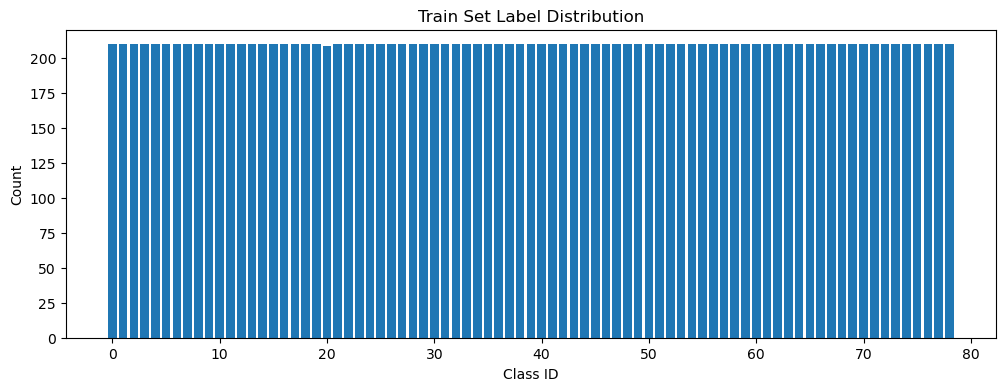

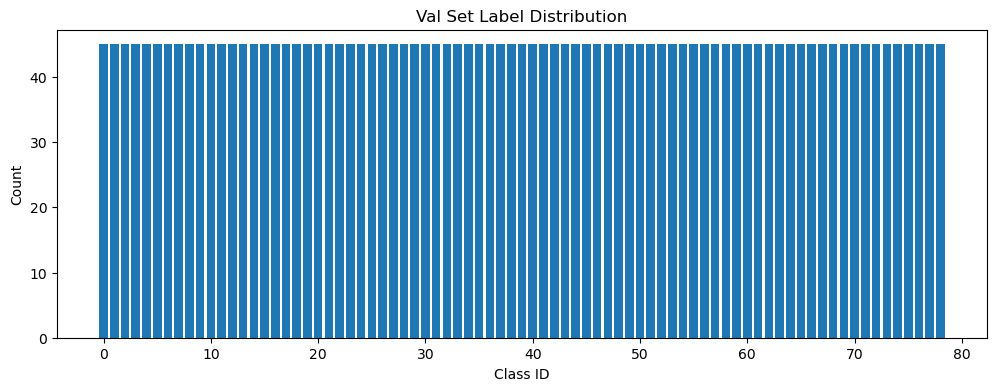

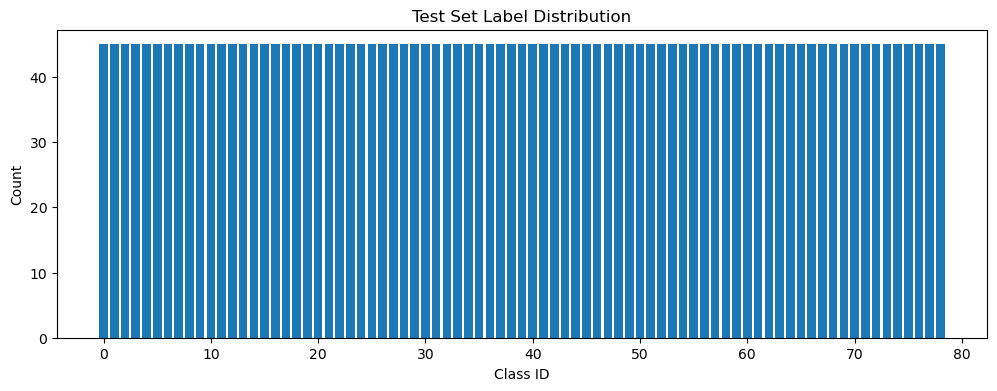

In [ ]:
# Check label distribution
import matplotlib.pyplot as plt
import numpy as np

def plot_label_distribution(label_ids, indices, split_name, label_encoder):
    subset_labels = [label_ids[i] for i in indices]Top-1 Accuracy: 0.8579
Top-5 Accuracy: 0.9643
Macro Precision: 0.8618
Macro Recall: 0.8579
Macro F1: 0.8572

Classification Report (per-class):
                             precision    recall  f1-score   support

    Abyssocucumis abyssorum       0.83      0.98      0.90        45
              Acanthascinae       0.76      0.87      0.81        45
              Acanthoptilum       0.90      0.96      0.92        45
                 Actinernus       0.90      0.82      0.86        45
                 Actiniaria       0.73      0.49      0.59        45
             Actinopterygii       0.88      0.78      0.82        45
                  Amphipoda       0.87      0.89      0.88        45
    Apostichopus leukothele       0.95      0.89      0.92        45
               Asbestopluma       0.86      0.84      0.85        45
     Asbestopluma monticola       0.83      0.87      0.85        45
    counts = np.bincount(subset_labels, minlength=len(label_encoder.classes_))
Top-1 Accuracy: 0.8579
Top-5 Accuracy: 0.9643
Macro Precision: 0.8618
Macro Recall: 0.8579
Macro F1: 0.8572

Classification Report (per-class):
                             precision    recall  f1-score   support

    Abyssocucumis abyssorum       0.83      0.98      0.90        45
              Acanthascinae       0.76      0.87      0.81        45
              Acanthoptilum       0.90      0.96      0.92        45
                 Actinernus       0.90      0.82      0.86        45
                 Actiniaria       0.73      0.49      0.59        45
             Actinopterygii       0.88      0.78      0.82        45
                  Amphipoda       0.87      0.89      0.88        45
    Apostichopus leukothele       0.95      0.89      0.92        45
               Asbestopluma       0.86      0.84      0.85        45
     Asbestopluma monticola       0.83      0.87      0.85        45
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(counts)), counts)
    plt.title(f"{split_name} Set Label Distribution")
    plt.xlabel("Class ID")
    plt.ylabel("Count")
    plt.show()

# Use this for each set:
plot_label_distribution(full_dataset.label_ids, train_idx, "Train", label_encoder)
plot_label_distribution(full_dataset.label_ids, val_idx, "Val", label_encoder)
plot_label_distribution(full_dataset.label_ids, test_idx, "Test", label_encoder)

In [68]:
# Count the images
print(f"Train set: {len(train_idx)} images")
print(f"Val set:   {len(val_idx)} images")
print(f"Test set:  {len(test_idx)} images")

total = len(train_idx) + len(val_idx) + len(test_idx)
print(f"Total:     {total} images")


Train set: 16589 images
Val set:   3555 images
Test set:  3555 images
Total:     23699 images


## Train model

In [69]:
# Initialize the model with the correct number of classes
model = FathomNetClassifier(num_classes=num_classes)
#model = FathomNetViTClassifier(num_classes=num_classes)


In [70]:
# Setup PyTorch Lightning Trainer with Early Stopping and Model Checkpoint
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    filename="best_model"
)
early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min",
    min_delta=0.001
)
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [71]:
early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min",
    min_delta=0.001) # Train the model
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | EfficientNet     | 53.0 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
53.0 M    Trainable params
0         Non-trainable params
53.0 M    Total params
211.978   Total estimated model params size (MB)
1025      Modules in train mode
0         Modules in eval mode


Epoch 12: 100%|██████████| 519/519 [01:13<00:00,  7.10it/s, v_num=4, train_loss=0.831, val_loss=1.270]


### Test the model

In [ ]:
# load the best model from checkpoint
best_model = FathomNetClassifier.load_from_checkpoint(
    checkpoint_callback.best_model_path,
    num_classes=len(label_encoder.classes_)
)

# move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = best_model.to(device)


In [74]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

# Test function
def evaluate_model(model, test_loader, label_encoder, device="cuda" if torch.cuda.is_available() else "cpu"):
    model = model.to(device)
    model.eval()

    all_preds = []
    all_top5_preds = []
    all_labels = []
    all_features = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            # Top-1 predictions
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Top-5 predictions
            top5 = torch.topk(outputs, k=5, dim=1).indices
            all_top5_preds.extend(top5.cpu().numpy())

            # Save features for kNN analysis later (optional)
            if hasattr(model.model, 'features'):
                feats = model.model.features(images)
                feats = torch.nn.functional.adaptive_avg_pool2d(feats, (1, 1)).view(feats.size(0), -1)
                all_features.append(feats.cpu().numpy())
            else:
                print("Warning: Model does not have 'features' attribute for kNN extraction.")

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_top5_preds = np.array(all_top5_preds)
    all_features = np.concatenate(all_features, axis=0) if all_features else None

    # Top-1 Accuracy
    top1_acc = accuracy_score(all_labels, all_preds)
    print(f"Top-1 Accuracy: {top1_acc:.4f}")

    # Top-5 Accuracy
    top5_acc = np.mean([label in top5 for label, top5 in zip(all_labels, all_top5_preds)])
    print(f"Top-5 Accuracy: {top5_acc:.4f}")

    # Macro Precision, Recall, F1
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")
    print(f"Macro Precision: {precision:.4f}")
    print(f"Macro Recall: {recall:.4f}")
    print(f"Macro F1: {f1:.4f}")

    # Classification Report (Per-Class Precision, Recall, F1)
    target_names = label_encoder.classes_
    print("\nClassification Report (per-class):")
    print(classification_report(all_labels, all_preds, target_names=target_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return all_preds, all_labels, all_features

Top-1 Accuracy: 0.8579
Top-5 Accuracy: 0.9643
Macro Precision: 0.8618
Macro Recall: 0.8579
Macro F1: 0.8572

Classification Report (per-class):
                             precision    recall  f1-score   support

    Abyssocucumis abyssorum       0.83      0.98      0.90        45
              Acanthascinae       0.76      0.87      0.81        45
              Acanthoptilum       0.90      0.96      0.92        45
                 Actinernus       0.90      0.82      0.86        45
                 Actiniaria       0.73      0.49      0.59        45
             Actinopterygii       0.88      0.78      0.82        45
                  Amphipoda       0.87      0.89      0.88        45
    Apostichopus leukothele       0.95      0.89      0.92        45
               Asbestopluma       0.86      0.84      0.85        45
     Asbestopluma monticola       0.83      0.87      0.85        45
                 Asteroidea       0.86      0.80      0.83        45
    Benthocodon pedunculata

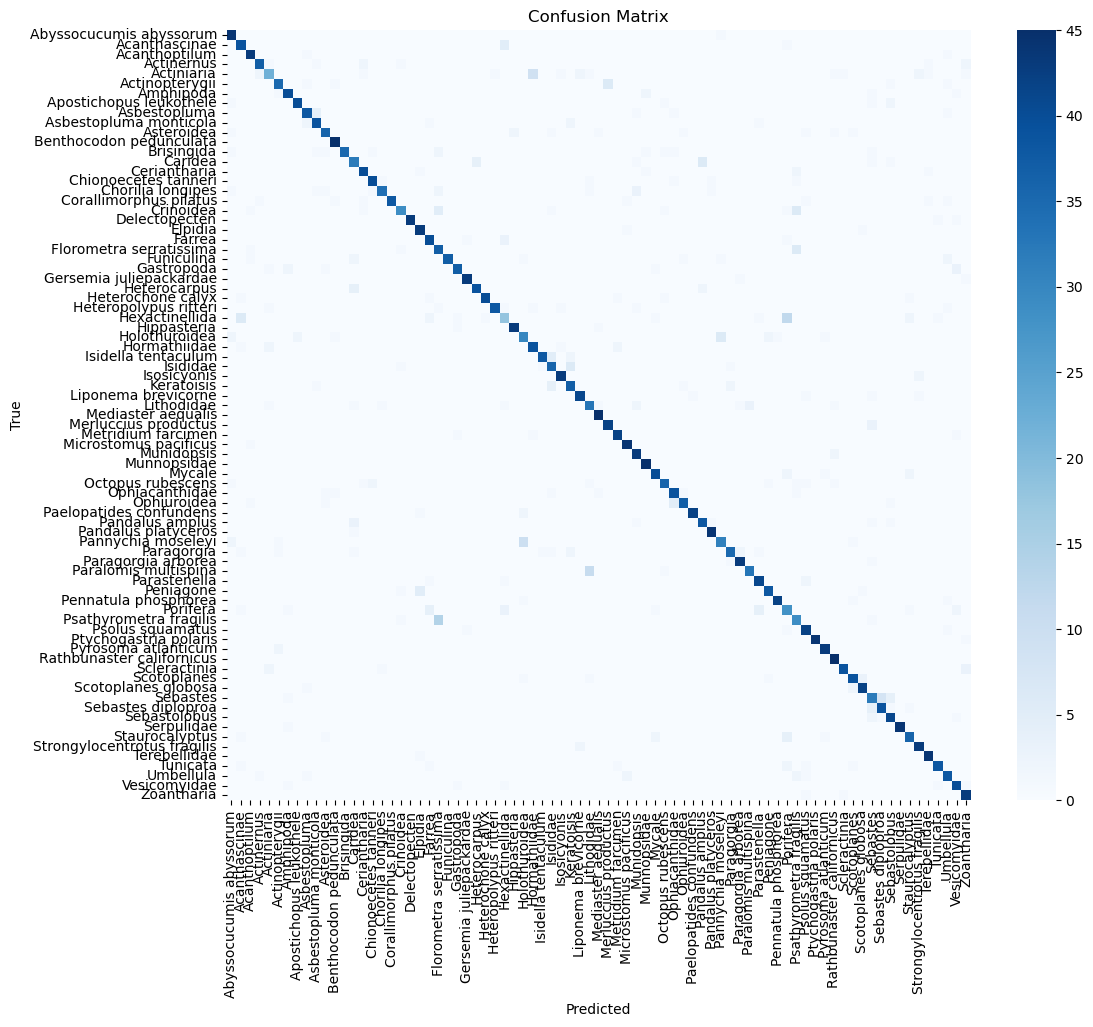

In [75]:
all_preds, all_labels, all_features = evaluate_model(best_model, test_loader, label_encoder, device)

In [76]:
import pandas as pd

# Save predictions vs labels
df_eval = pd.DataFrame({
    "true_label": label_encoder.inverse_transform(all_labels),
    "predicted_label": label_encoder.inverse_transform(all_preds)
})
df_eval.to_csv("test_predictions.csv", index=False)

## Predict test dataset

In [77]:
# Load and transform the test dataset
test_dataset = FathomNetDataset(csv_path="test/annotations.csv", transform=test_transforms, label_encoder=label_encoder, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [79]:
# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the best model and move it to the correct device
best_model = FathomNetClassifier.load_from_checkpoint(
    checkpoint_callback.best_model_path,
    num_classes=len(label_encoder.classes_)
)
best_model = best_model.to(device)  # Send model to the device

# Generate predictions for the test dataset
predictions = []
ids = []

# Set the model to evaluation mode
best_model.eval()

# No gradients needed for inference
with torch.no_grad():
    for batch in test_loader:
        images, image_ids = batch
        images = images.to(device)  # Send input images to the same device as the model

        logits = best_model(images)
        preds = torch.argmax(logits, dim=1).tolist()
        predictions.extend(preds)
        ids.extend(image_ids)

# Decode numeric predictions to original string labels
decoded_predictions = label_encoder.inverse_transform(predictions)

## Create submission file

In [80]:
# Save predictions to the test annotations CSV file
submission_df = pd.read_csv("test/annotations.csv")
submission_df["annotation_id"] = range(1, len(submission_df) + 1)
submission_df["concept_name"] = decoded_predictions
submission_df = submission_df.drop(["path", "label"], axis=1)
submission_df.to_csv("submission.csv", index=False)
submission_df.head()

,annotation_id,concept_name
0,1,Caridea
1,2,Funiculina
2,3,Funiculina
3,4,Funiculina
4,5,Funiculina


In [81]:
import os
import subprocess
import shutil

os.environ['KAGGLE_USERNAME'] = "danzimmerman"
os.environ['KAGGLE_KEY'] = "dbf4dbbe037ec259684ff4f36093b1f4"

kaggle_path = shutil.which("kaggle")

subprocess.run([
    kaggle_path, "competitions", "submit", 
    "-c", "fathomnet-2025", 
    "-f", "submission.csv", 
    "-m", "Auto-submission"
])


100%|██████████| 14.5k/14.5k [00:00<00:00, 53.5kB/s]


Successfully submitted to FathomNet 2025 @ CVPR-FGVC

CompletedProcess(args=['/home/dzimmerman2021/miniconda3/envs/fathomnet_comp/bin/kaggle', 'competitions', 'submit', '-c', 'fathomnet-2025', '-f', 'submission.csv', '-m', 'Auto-submission'], returncode=0)

### Format data for YOLO

In [ ]:
# Create class map
import pandas as pd

df = pd.read_csv("train/annotations.csv")
classes = sorted(df["label"].dropna().unique())
class_to_id = {cls: i for i, cls in enumerate(classes)}
print(class_to_id)

{'Abyssocucumis abyssorum': 0, 'Acanthascinae': 1, 'Acanthoptilum': 2, 'Actinernus': 3, 'Actiniaria': 4, 'Actinopterygii': 5, 'Amphipoda': 6, 'Apostichopus leukothele': 7, 'Asbestopluma': 8, 'Asbestopluma monticola': 9, 'Asteroidea': 10, 'Benthocodon pedunculata': 11, 'Brisingida': 12, 'Caridea': 13, 'Ceriantharia': 14, 'Chionoecetes tanneri': 15, 'Chorilia longipes': 16, 'Corallimorphus pilatus': 17, 'Crinoidea': 18, 'Delectopecten': 19, 'Elpidia': 20, 'Farrea': 21, 'Florometra serratissima': 22, 'Funiculina': 23, 'Gastropoda': 24, 'Gersemia juliepackardae': 25, 'Heterocarpus': 26, 'Heterochone calyx': 27, 'Heteropolypus ritteri': 28, 'Hexactinellida': 29, 'Hippasteria': 30, 'Holothuroidea': 31, 'Hormathiidae': 32, 'Isidella tentaculum': 33, 'Isididae': 34, 'Isosicyonis': 35, 'Keratoisis': 36, 'Liponema brevicorne': 37, 'Lithodidae': 38, 'Mediaster aequalis': 39, 'Merluccius productus': 40, 'Metridium farcimen': 41, 'Microstomus pacificus': 42, 'Munidopsis': 43, 'Munnopsidae': 44, 'My

In [ ]:
# Define helper for YOLO labels for split
import os
from PIL import Image

def write_yolo_labels(subset_indices, subset_name, dataset, class_to_id):
    label_output_dir = f"yolo_dataset/labels/{subset_name}/"
    image_output_dir = f"yolo_dataset/images/{subset_name}/"
    os.makedirs(label_output_dir, exist_ok=True)
    os.makedirs(image_output_dir, exist_ok=True)

    for idx in subset_indices:
        img_tensor, label = dataset[idx]
        img_path = dataset.image_paths[idx]
        label_name = dataset.labels[idx]

        # Get original image size
        img = Image.open(img_path)

        # Save the image to YOLO directory
        img_basename = os.path.basename(img_path)
        img_output_path = os.path.join(image_output_dir, img_basename)
        img.save(img_output_path)

        # Since this is a cropped ROI, full image is the box
        x_center = 0.5
        y_center = 0.5
        width = 1.0
        height = 1.0

        class_id = class_to_id[label_name]

        label_output_path = os.path.join(label_output_dir, os.path.splitext(img_basename)[0] + ".txt")
        with open(label_output_path, "w") as f:
            f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")


In [ ]:
# Run for all splits ### full_dataset = FathomNetDataset(...)
write_yolo_labels(train_idx, "train", full_dataset, class_to_id)
write_yolo_labels(val_idx, "val", full_dataset, class_to_id)
write_yolo_labels(test_idx, "test", full_dataset, class_to_id)


In [ ]:
# Create data.yaml
with open("yolo_dataset/data.yaml", "w") as f:
    f.write("path: yolo_dataset\n")
    f.write("train: images/train\n")
    f.write("val: images/val\n")
    f.write("test: images/test\n\n")
    f.write("names:\n")
    for i, name in enumerate(classes):
        f.write(f"  {i}: {name}\n")

### Train YOLOv8

In [1]:
import torch
import torchvision
print("Torch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())


Torch: 2.1.0
Torchvision: 0.16.0
CUDA available: True


In [ ]:
from ultralytics import YOLO

model = YOLO("/home/dzimmerman2021/Documents/fathomnet/fathomnet-models/mbari_315k_yolov8.pt")
model.train(data="./data.yaml", epochs=100, imgsz=640, batch=16, device="cuda")


Ultralytics 8.3.121 🚀 Python-3.10.17 torch-2.1.0 CUDA:0 (NVIDIA A100 80GB PCIe, 81038MiB)
engine/trainer: task=detect, mode=train, model=/home/dzimmerman2021/Documents/fathomnet/fathomnet-models/mbari_315k_yolov8.pt, data=./data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, 

train: Scanning /home/dzimmerman2021/Documents/fathomnet/yolo_dataset/labels/train... 16559 images, 0 backgrounds, 30 corrupt: 100%|██████████| 16589/16589 [00:10<00:00, 1574.79it/s]

train: /home/dzimmerman2021/Documents/fathomnet/yolo_dataset/images/train/1113_4255.png: ignoring corrupt image/label: image size (9, 13) <10 pixels
train: /home/dzimmerman2021/Documents/fathomnet/yolo_dataset/images/train/1188_4560.png: ignoring corrupt image/label: image size (22, 9) <10 pixels
train: /home/dzimmerman2021/Documents/fathomnet/yolo_dataset/images/train/167_630.png: ignoring corrupt image/label: image size (9, 13) <10 pixels
train: /home/dzimmerman2021/Documents/fathomnet/yolo_dataset/images/train/1816_6578.png: ignoring corrupt image/label: image size (9, 38) <10 pixels
train: /home/dzimmerman2021/Documents/fathomnet/yolo_dataset/images/train/1984_7084.png: ignoring corrupt image/label: image size (18, 8) <10 pixels
train: /home/dzimmerman2021/Documents/fathomnet/yolo_dataset/images/train/1984_7096.png: ignoring corrupt image/label: image size (13, 7) <10 pixels
train: /home/dzimmerman2021/Documents/fathomnet/yolo_dataset/images/train/1984_7104.png: ignoring corrupt im

train: New cache created: /home/dzimmerman2021/Documents/fathomnet/yolo_dataset/labels/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 484.8±361.3 MB/s, size: 15.0 KB)


val: Scanning /home/dzimmerman2021/Documents/fathomnet/yolo_dataset/labels/val... 3545 images, 0 backgrounds, 10 corrupt: 100%|██████████| 3555/3555 [00:02<00:00, 1609.57it/s]

val: /home/dzimmerman2021/Documents/fathomnet/yolo_dataset/images/val/1816_6563.png: ignoring corrupt image/label: image size (4, 27) <10 pixels
val: /home/dzimmerman2021/Documents/fathomnet/yolo_dataset/images/val/1984_7121.png: ignoring corrupt image/label: image size (13, 9) <10 pixels
val: /home/dzimmerman2021/Documents/fathomnet/yolo_dataset/images/val/3806_12085.png: ignoring corrupt image/label: image size (9, 8) <10 pixels
val: /home/dzimmerman2021/Documents/fathomnet/yolo_dataset/images/val/3837_12146.png: ignoring corrupt image/label: image size (16, 9) <10 pixels
val: /home/dzimmerman2021/Documents/fathomnet/yolo_dataset/images/val/3837_12147.png: ignoring corrupt image/label: image size (28, 6) <10 pixels
val: /home/dzimmerman2021/Documents/fathomnet/yolo_dataset/images/val/3906_12387.png: ignoring corrupt image/label: image size (9, 25) <10 pixels
val: /home/dzimmerman2021/Documents/fathomnet/yolo_dataset/images/val/5083_15348.png: ignoring corrupt image/label: image size 

Plotting labels to runs/detect/train9/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train9
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      13.6G     0.2022      2.667     0.9829         43        640: 100%|██████████| 1035/1035 [04:03<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:21<00:00,  5.05it/s]


                   all       3545       3545      0.529       0.53      0.547      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      15.6G     0.1279      1.614      0.894         48        640: 100%|██████████| 1035/1035 [03:57<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.67it/s]


                   all       3545       3545      0.586      0.579      0.619      0.618

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      15.6G     0.1536      1.585     0.8955         48        640: 100%|██████████| 1035/1035 [03:54<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.67it/s]


                   all       3545       3545       0.45       0.43      0.439      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      15.6G     0.1462      1.626     0.8952         55        640: 100%|██████████| 1035/1035 [03:49<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.68it/s]


                   all       3545       3545      0.462      0.322      0.308      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      15.6G     0.1203      1.516     0.8859         49        640: 100%|██████████| 1035/1035 [03:49<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.69it/s]


                   all       3545       3545      0.582      0.568      0.612      0.612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      15.6G     0.1047      1.421     0.8818         49        640: 100%|██████████| 1035/1035 [03:49<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.72it/s]


                   all       3545       3545      0.634      0.644      0.699      0.698

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      15.6G    0.09453      1.354     0.8785         53        640: 100%|██████████| 1035/1035 [03:48<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.69it/s]


                   all       3545       3545      0.656      0.616       0.68       0.68

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      15.6G    0.08651      1.305     0.8775         45        640: 100%|██████████| 1035/1035 [03:50<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.72it/s]


                   all       3545       3545      0.659      0.635        0.7      0.699

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      15.6G    0.08206      1.245     0.8776         45        640: 100%|██████████| 1035/1035 [03:49<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.63it/s]


                   all       3545       3545      0.656      0.626       0.69       0.69

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      15.6G     0.0772      1.211      0.877         52        640: 100%|██████████| 1035/1035 [03:50<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.74it/s]


                   all       3545       3545      0.669      0.657      0.726      0.726

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      15.6G      0.073      1.159     0.8746         37        640: 100%|██████████| 1035/1035 [03:50<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.72it/s]


                   all       3545       3545      0.737      0.718      0.791       0.79

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      15.6G    0.06889       1.12     0.8737         52        640: 100%|██████████| 1035/1035 [03:49<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.72it/s]


                   all       3545       3545      0.737      0.738      0.804      0.803

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      15.6G        inf      1.087     0.8727         45        640: 100%|██████████| 1035/1035 [03:50<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.72it/s]

                   all       3545       3545      0.761      0.737      0.815      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      15.6G    0.06495      1.067     0.8746         44        640: 100%|██████████| 1035/1035 [03:49<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.70it/s]

                   all       3545       3545      0.783      0.724      0.816      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      15.6G    0.06254      1.055      0.872         46        640: 100%|██████████| 1035/1035 [03:48<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.74it/s]

                   all       3545       3545      0.768      0.772      0.838      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      15.6G    0.06054      1.024     0.8727         40        640: 100%|██████████| 1035/1035 [03:49<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.75it/s]

                   all       3545       3545      0.772       0.74      0.832      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      15.6G     0.0585     0.9901     0.8735         52        640: 100%|██████████| 1035/1035 [03:49<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.68it/s]


                   all       3545       3545      0.799      0.784      0.859      0.859

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      15.6G    0.05739     0.9723     0.8716         44        640: 100%|██████████| 1035/1035 [03:49<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.72it/s]


                   all       3545       3545      0.801      0.799      0.865      0.865

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      15.6G    0.05586     0.9578     0.8705         45        640: 100%|██████████| 1035/1035 [03:49<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.71it/s]

                   all       3545       3545      0.795        0.8       0.86       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      15.6G    0.05452     0.9377     0.8727         49        640: 100%|██████████| 1035/1035 [03:49<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.74it/s]


                   all       3545       3545      0.812      0.801       0.87       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      15.6G        inf     0.9215     0.8706         50        640: 100%|██████████| 1035/1035 [03:50<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.79it/s]

                   all       3545       3545      0.842      0.787       0.88       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      15.6G     0.0516     0.9082     0.8705         41        640: 100%|██████████| 1035/1035 [03:49<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.77it/s]

                   all       3545       3545      0.815      0.815      0.879      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      15.6G    0.05062      0.891     0.8707         47        640: 100%|██████████| 1035/1035 [03:49<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.78it/s]


                   all       3545       3545      0.853      0.804      0.888      0.887

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      15.6G      0.048     0.8699     0.8711         45        640: 100%|██████████| 1035/1035 [03:49<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.77it/s]

                   all       3545       3545      0.822       0.83      0.892      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      15.6G    0.04911     0.8547     0.8711         47        640: 100%|██████████| 1035/1035 [03:49<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.73it/s]


                   all       3545       3545      0.843      0.809      0.891      0.891

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      15.6G        inf     0.8446     0.8711         49        640: 100%|██████████| 1035/1035 [03:50<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.71it/s]

                   all       3545       3545      0.823       0.83      0.891      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      15.6G    0.04841      0.835     0.8711         51        640: 100%|██████████| 1035/1035 [03:50<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.72it/s]

                   all       3545       3545      0.835      0.837      0.901      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      15.6G        inf     0.8151       0.87         48        640: 100%|██████████| 1035/1035 [03:49<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.72it/s]

                   all       3545       3545      0.844      0.833      0.901      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      15.6G    0.04566     0.8046     0.8701         47        640: 100%|██████████| 1035/1035 [03:49<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.75it/s]

                   all       3545       3545      0.862      0.831      0.905      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      15.6G    0.04479      0.801     0.8694         49        640: 100%|██████████| 1035/1035 [03:49<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.74it/s]

                   all       3545       3545      0.823      0.867      0.908      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      15.6G    0.04358     0.7779     0.8698         42        640: 100%|██████████| 1035/1035 [03:49<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.74it/s]

                   all       3545       3545      0.843      0.842      0.904      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      15.6G    0.04369     0.7625     0.8714         46        640: 100%|██████████| 1035/1035 [03:51<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.66it/s]


                   all       3545       3545       0.85      0.841      0.906      0.906

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      15.6G    0.04336     0.7535     0.8695         45        640: 100%|██████████| 1035/1035 [03:52<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.71it/s]

                   all       3545       3545       0.86      0.842      0.911      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      15.6G    0.04253     0.7425     0.8691         50        640: 100%|██████████| 1035/1035 [03:51<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.72it/s]

                   all       3545       3545       0.86      0.856      0.915      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      15.6G    0.04158     0.7372     0.8687         44        640: 100%|██████████| 1035/1035 [03:51<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.69it/s]


                   all       3545       3545      0.874      0.851      0.916      0.916

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      15.6G    0.04051     0.7186     0.8691         45        640: 100%|██████████| 1035/1035 [03:49<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.75it/s]

                   all       3545       3545      0.877      0.858      0.919      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      15.6G    0.03989     0.7174     0.8694         51        640: 100%|██████████| 1035/1035 [03:49<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.75it/s]

                   all       3545       3545      0.874      0.857      0.919      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      15.6G    0.04004     0.7107     0.8699         40        640: 100%|██████████| 1035/1035 [03:48<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.76it/s]

                   all       3545       3545      0.861      0.864      0.918      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      15.6G        inf     0.6977     0.8686         51        640: 100%|██████████| 1035/1035 [03:48<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.72it/s]

                   all       3545       3545       0.86      0.869      0.918      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      15.6G    0.03881     0.6884     0.8694         45        640: 100%|██████████| 1035/1035 [03:48<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.76it/s]

                   all       3545       3545      0.851      0.878      0.919      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      15.6G        inf     0.6724     0.8688         49        640: 100%|██████████| 1035/1035 [03:49<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.75it/s]

                   all       3545       3545      0.884      0.854       0.92       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      15.6G    0.03673     0.6725     0.8699         48        640: 100%|██████████| 1035/1035 [03:50<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.74it/s]

                   all       3545       3545      0.887      0.852      0.923      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      15.6G        inf     0.6584     0.8684         44        640: 100%|██████████| 1035/1035 [03:49<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.76it/s]

                   all       3545       3545      0.874      0.861      0.923      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      15.6G    0.03601     0.6563     0.8696         45        640: 100%|██████████| 1035/1035 [03:48<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.75it/s]

                   all       3545       3545      0.884      0.852      0.924      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      15.6G        inf     0.6429     0.8674         51        640: 100%|██████████| 1035/1035 [03:48<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.74it/s]


                   all       3545       3545      0.874      0.864      0.924      0.924

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      15.6G    0.03556     0.6314     0.8681         50        640: 100%|██████████| 1035/1035 [03:48<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.74it/s]

                   all       3545       3545      0.887       0.86      0.925      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      15.6G    0.03462     0.6221      0.868         49        640: 100%|██████████| 1035/1035 [03:48<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [00:19<00:00,  5.74it/s]

                   all       3545       3545      0.864      0.882      0.926      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      15.6G        inf     0.6147     0.8674         53        640:  55%|█████▍    | 569/1035 [02:05<01:43,  4.52it/s]

### Plot Lightning Logs

In [84]:
%load_ext tensorboard
%tensorboard --logdir=lightning_logs/


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2303135), started 11:35:12 ago. (Use '!kill 2303135' to kill it.)